In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [ ]:
import zipfile, os

zip_path = "/content/Data.zip"  # adjust if the name differs
extract_dir = "data"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# confirm corpus
!ls data | head

Data
__MACOSX


In [ ]:
import os, random, re, math, pickle, time
from collections import Counter, deque, defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
def load_corpus(path):
    words = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            w = line.strip().lower()
            w = re.sub(r'[^a-z]', '', w)
            if w:
                words.append(w)
    return words

In [ ]:
class CharHMM:
    def __init__(self, alphabet=None):
        if alphabet is None:
            alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]
        self.chars = alphabet
        self.C = len(self.chars)
        self.c2i = {c:i for i,c in enumerate(self.chars)}
        self.i2c = {i:c for c,i in self.c2i.items()}
        self.pi = np.zeros(self.C)
        self.A = np.zeros((self.C, self.C))
        self.trained = False

    def fit(self, words):
        # Train simple first-order char Markov counts
        for w in tqdm(words, desc="HMM fit"):
            if len(w)==0: continue
            self.pi[self.c2i[w[0]]] += 1
            for a,b in zip(w, w[1:]):
                self.A[self.c2i[a], self.c2i[b]] += 1
        # smooth + normalize
        self.pi += 1e-6
        self.A += 1e-6
        self.pi /= self.pi.sum()
        row_sums = self.A.sum(axis=1, keepdims=True)
        row_sums[row_sums==0] = 1.0
        self.A = self.A / row_sums
        self.trained = True

    def score_word(self, w):
        # log-prob under char markov
        if not self.trained: return -1e9
        s = math.log(self.pi[self.c2i[w[0]]])
        for a,b in zip(w, w[1:]):
            s += math.log(self.A[self.c2i[a], self.c2i[b]])
        return s

    def predict_from_candidates(self, candidates, masked_word, guessed):
        # candidates: list of words matching pattern
        # returns dict {letter:score}
        pos_counts = [Counter() for _ in range(len(masked_word))]
        for w in candidates:
            for i,ch in enumerate(w):
                if masked_word[i] == '_' and ch not in guessed:
                    pos_counts[i][ch] += 1
        letter_scores = Counter()
        for pc in pos_counts:
            for ch,cnt in pc.items():
                letter_scores[ch] += cnt
        total = sum(letter_scores.values())
        if total == 0:
            return {c:1.0/len(self.chars) for c in self.chars}
        return {c: letter_scores.get(c, 0)/total for c in self.chars}

In [ ]:
# 4) Candidate filtering util
# -------------------------
def get_candidates_by_mask(corpus, masked, guessed):
    L = len(masked)
    candidates = []
    for w in corpus:
        if len(w)!=L: continue
        ok = True
        for i, (m,ch) in enumerate(zip(masked, w)):
            if m != '_' and m != ch:
                ok = False; break
            if m == '_' and ch in guessed:
                ok = False; break
        if ok:
            candidates.append(w)
    return candidates

# -------------------------
# 5) Hangman Environment
# -------------------------
class HangmanEnv:
    def __init__(self, corpus, hmm=None, max_wrong=6):
        self.corpus = corpus
        self.hmm = hmm
        self.max_wrong = max_wrong
        self.alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]
        self.reset()

    def reset(self, word=None):
        if word is None:
            self.word = random.choice(self.corpus)
        else:
            self.word = word
        self.masked = ['_'] * len(self.word)
        self.guessed = set()
        self.wrong = 0
        self.done = False
        return self.get_state()

    def get_state(self):
        masked_str = "".join(self.masked)
        guessed_mask = np.array([1.0 if c in self.guessed else 0.0 for c in self.alphabet], dtype=np.float32)
        # HMM probability vector
        if self.hmm:
            candidates = get_candidates_by_mask(self.corpus, masked_str, self.guessed)
            probs = self.hmm.predict_from_candidates(candidates, masked_str, self.guessed)
            prob_vec = np.array([probs.get(c,0.0) for c in self.alphabet], dtype=np.float32)
            if prob_vec.sum() > 0:
                prob_vec = prob_vec / prob_vec.sum()
        else:
            prob_vec = np.zeros(len(self.alphabet), dtype=np.float32)
        lives_norm = np.array([ (self.max_wrong - self.wrong) / float(self.max_wrong) ], dtype=np.float32)
        state = {
            'masked': masked_str,
            'guessed_mask': guessed_mask,
            'hmm_probs': prob_vec,
            'lives': lives_norm
        }
        return state

    def step(self, action_letter):
        if self.done:
            raise ValueError("Episode finished")
        info = {}
        repeated = False
        if action_letter in self.guessed:
            self.wrong += 0  # keep wrong same, but penalize externally
            repeated = True
            reward = -0.5
        else:
            self.guessed.add(action_letter)
            if action_letter in self.word:
                for i,ch in enumerate(self.word):
                    if ch == action_letter:
                        self.masked[i] = ch
                reward = 1.0
            else:
                self.wrong += 1
                reward = -1.0
        # terminal checks
        if '_' not in self.masked:
            self.done = True
            reward += 10.0
            info['success'] = True
        elif self.wrong > self.max_wrong:
            self.done = True
            reward -= 5.0
            info['success'] = False
        else:
            info['success'] = None
        info['repeated'] = repeated
        return self.get_state(), reward, self.done, info


In [ ]:
# 6) Tabular Q-Learning Agent
# -------------------------
class QLearningAgent:
    def __init__(self, alphabet=None, lr=0.1, gamma=0.99, epsilon=1.0, eps_min=0.05, eps_decay=0.9995):
        if alphabet is None:
            alphabet = [chr(i) for i in range(ord('a'), ord('z')+1)]
        self.alphabet = alphabet
        self.n = len(alphabet)
        self.q = defaultdict(lambda: np.zeros(self.n, dtype=np.float32))
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_decay = eps_decay

    def state_to_key(self, masked, guessed_mask):
        # key: masked string + tuple of guessed letters (or bitmask)
        return masked + "|" + "".join(map(str, guessed_mask.astype(int).tolist()))

    def act(self, state, explore=True):
        key = self.state_to_key(state['masked'], state['guessed_mask'])
        allowed = np.array([1 if state['guessed_mask'][i]==0 else 0 for i in range(self.n)], dtype=bool)
        if explore and random.random() < self.epsilon:
            choices = np.where(allowed)[0]
            if len(choices)==0:
                return random.choice(range(self.n))
            return int(np.random.choice(choices))
        qv = self.q[key]
        qv_masked = np.copy(qv)
        qv_masked[~allowed] = -1e9
        return int(np.argmax(qv_masked))

    def update(self, state, action_idx, reward, next_state, done):
        key = self.state_to_key(state['masked'], state['guessed_mask'])
        next_key = self.state_to_key(next_state['masked'], next_state['guessed_mask'])
        best_next = 0.0 if done else float(np.max(self.q[next_key]))
        target = reward + self.gamma * best_next
        self.q[key][action_idx] += self.lr * (target - self.q[key][action_idx])
        # decay epsilon
        if self.epsilon > self.eps_min:
            self.epsilon *= self.eps_decay

    def save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(dict(self.q), f)

    def load(self, path):
        with open(path, 'rb') as f:
            qdict = pickle.load(f)
            self.q = defaultdict(lambda: np.zeros(self.n, dtype=np.float32), qdict)


In [ ]:
# 7) DQN Agent (PyTorch)
# -------------------------
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
except Exception as e:
    torch = None
    print("Torch not installed; DQN will not be available unless you install torch.")

if torch is not None:
    class DQNNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, output_dim)
            )
        def forward(self, x):
            return self.net(x)

    class DQNAgent:
        def __init__(self, input_dim, n_actions, device='cpu', lr=1e-4, gamma=0.99, batch_size=64, buffer_capacity=50000):
            self.device = torch.device(device)
            self.net = DQNNet(input_dim, n_actions).to(self.device)
            self.target = DQNNet(input_dim, n_actions).to(self.device)
            self.target.load_state_dict(self.net.state_dict())
            self.opt = optim.Adam(self.net.parameters(), lr=lr)
            self.gamma = gamma
            self.batch_size = batch_size
            self.replay = deque(maxlen=buffer_capacity)
            self.n_actions = n_actions
            self.loss_fn = nn.MSELoss()
            self.steps = 0
        def state_to_vec(self, state):
            # flatten: masked one-hot per char position? Simpler: use HMM prob (26) + guessed_mask (26) + lives (1)
            return np.concatenate([state['hmm_probs'], state['guessed_mask'], state['lives']]).astype(np.float32)
        def act(self, state, eps=0.05):
            vec = self.state_to_vec(state)
            if random.random() < eps:
                allowed = np.where(state['guessed_mask']==0)[0]
                return int(np.random.choice(allowed)) if len(allowed)>0 else random.randint(0, self.n_actions-1)
            with torch.no_grad():
                t = torch.tensor(vec, dtype=torch.float32, device=self.device).unsqueeze(0)
                q = self.net(t).cpu().numpy().squeeze()
                q[state['guessed_mask']==1] = -1e9
                return int(np.argmax(q))
        def push(self, s,a,r,ns,done):
            self.replay.append((s,a,r,ns,done))
        def train_step(self):
            if len(self.replay) < self.batch_size:
                return None
            batch = random.sample(self.replay, self.batch_size)
            s_b = torch.tensor([self.state_to_vec(b[0]) for b in batch], dtype=torch.float32, device=self.device)
            a_b = torch.tensor([b[1] for b in batch], dtype=torch.long, device=self.device)
            r_b = torch.tensor([b[2] for b in batch], dtype=torch.float32, device=self.device)
            ns_b = torch.tensor([self.state_to_vec(b[3]) for b in batch], dtype=torch.float32, device=self.device)
            done_b = torch.tensor([b[4] for b in batch], dtype=torch.float32, device=self.device)
            q_vals = self.net(s_b)
            q_a = q_vals.gather(1, a_b.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                q_next = self.target(ns_b)
                q_next[torch.tensor([b[3]['guessed_mask']==1 for b in batch], dtype=torch.bool, device=self.device)] = -1e9
                q_next_max = q_next.max(1)[0]
                target = r_b + self.gamma * q_next_max * (1.0 - done_b)
            loss = self.loss_fn(q_a, target)
            self.opt.zero_grad(); loss.backward(); self.opt.step()
            self.steps += 1
            if self.steps % 500 == 0:
                self.target.load_state_dict(self.net.state_dict())
            return loss.item()
        def save(self, path):
            torch.save({'net': self.net.state_dict(), 'target': self.target.state_dict()}, path)
        def load(self, path):
            ckpt = torch.load(path, map_location=self.device)
            self.net.load_state_dict(ckpt['net'])
            self.target.load_state_dict(ckpt['target'])

In [ ]:
# 8) Training & evaluation helpers
# -------------------------
def evaluate_policy(env_corpus, hmm, agent_obj, alg="qlearn", n_games=200, verbose=False):
    wins = wrong = repeated = 0
    total_accuracy = 0.0
    for w in random.sample(env_corpus, n_games):
        env = HangmanEnv(env_corpus, hmm)
        state = env.reset(word=w)
        done = False
        correct = 0
        total_guesses = 0
        while not done:
            if alg == "qlearn":
                act_idx = agent_obj.act(state, explore=False)
            else:
                eps = 0.0
                act_idx = agent_obj.act(state, eps=eps)
            letter = env.alphabet[act_idx]
            next_state, reward, done, info = env.step(letter)
            total_guesses += 0 if info.get('repeated', False) else 1
            if reward > 0:
                correct += 1
            if verbose:
                print(letter, "".join(env.masked), reward)
            state = next_state
        wins += int(info.get('success', False))
        wrong += env.wrong
        repeated += 0  # our agents avoid repeats; can track if needed
        # accuracy per game
        acc = correct / max(1, total_guesses)
        total_accuracy += acc
    success_rate = wins / n_games
    avg_wrong = wrong / n_games
    avg_repeated = repeated / n_games
    avg_accuracy = total_accuracy / n_games
    final_score = (success_rate * 2000) - (wrong * 5) - (repeated * 2)
    return {
        'success_rate': success_rate,
        'avg_wrong': avg_wrong,
        'avg_repeated': avg_repeated,
        'avg_accuracy': avg_accuracy,
        'final_score': final_score
    }

In [ ]:
# 9) Q-learning training loop
# -------------------------
def train_qlearning(train_corpus, hmm, episodes=5000, eval_every=1000):
    env = HangmanEnv(train_corpus, hmm)
    agent = QLearningAgent()
    rewards_history = []
    for ep in tqdm(range(episodes), desc="Q-learn train"):
        w = random.choice(train_corpus)
        state = env.reset(word=w)
        done = False
        ep_reward = 0.0
        while not done:
            a_idx = agent.act(state, explore=True)
            letter = env.alphabet[a_idx]
            ns, r, done, info = env.step(letter)
            agent.update(state, a_idx, r, ns, done)
            ep_reward += r
            state = ns
        rewards_history.append(ep_reward)
        if (ep+1) % eval_every == 0:
            stats = evaluate_policy(train_corpus, hmm, agent, alg="qlearn", n_games=200)
            print(f"Ep {ep+1} eval on train: success={stats['success_rate']:.3f} acc={stats['avg_accuracy']:.3f} score={stats['final_score']:.2f}")
    return agent, rewards_history

In [ ]:
# 10) DQN training loop
# -------------------------
def train_dqn(train_corpus, hmm, episodes=2000, batch_size=64, eval_every=500):
    if torch is None:
        raise RuntimeError("Torch not installed. Install torch to run DQN.")
    env = HangmanEnv(train_corpus, hmm)
    # input_dim = len(hmm alphabet prob) + len(alphabet guessed mask) + 1 life
    input_dim = 26 + 26 + 1
    agent = DQNAgent(input_dim, 26, device='cpu', lr=1e-4, batch_size=batch_size)
    rewards = []
    eps_start = 1.0; eps_end = 0.05; eps_decay = episodes*0.6
    for ep in tqdm(range(episodes), desc="DQN train"):
        w = random.choice(train_corpus)
        state = env.reset(word=w)
        done = False
        ep_reward = 0.0
        eps = eps_end + (eps_start - eps_end) * math.exp(-1. * ep / eps_decay)
        while not done:
            action = agent.act(state, eps=eps)
            letter = env.alphabet[action]
            ns, r, done, info = env.step(letter)
            agent.push(state, action, r, ns, float(done))
            loss = agent.train_step()
            state = ns
            ep_reward += r
        rewards.append(ep_reward)
        if (ep+1) % eval_every == 0:
            stats = evaluate_policy(train_corpus, hmm, agent, alg="dqn", n_games=200)
            print(f"Ep {ep+1} eval on train: success={stats['success_rate']:.3f} acc={stats['avg_accuracy']:.3f} score={stats['final_score']:.2f}")
    return agent, rewards

In [ ]:
# 11) Plot helper
# -------------------------
def plot_rewards(rewards, title="Rewards"):
    plt.figure(figsize=(8,4))
    plt.plot(rewards, alpha=0.7)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

Loading corpus...
Loaded 50000 words.
Train: 40000 | Test: 10000
Training HMM...


HMM fit: 100%|██████████| 40000/40000 [00:00<00:00, 151760.79it/s]


HMM saved to hmm_model.pkl
Training Q-learning agent (quick)...


Q-learn train:  25%|██▌       | 1003/4000 [02:05<1:48:40,  2.18s/it]

Ep 1000 eval on train: success=0.010 acc=0.306 score=-6960.00


Q-learn train:  50%|█████     | 2002/4000 [04:07<1:48:53,  3.27s/it]

Ep 2000 eval on train: success=0.005 acc=0.308 score=-6980.00


Q-learn train:  75%|███████▌  | 3000/4000 [06:09<1:08:03,  4.08s/it]

Ep 3000 eval on train: success=0.005 acc=0.285 score=-6985.00


Q-learn train: 100%|██████████| 4000/4000 [08:09<00:00,  8.18it/s]

Ep 4000 eval on train: success=0.005 acc=0.300 score=-6980.00
Q-learning training finished.



Evaluate on training set:
{'success_rate': 0.016, 'avg_wrong': 6.97, 'avg_repeated': 0.0, 'avg_accuracy': 0.3074812992563001, 'final_score': -17393.0}

Evaluate on test set:
{'success_rate': 0.008, 'avg_wrong': 6.992, 'avg_repeated': 0.0, 'avg_accuracy': 0.31272049094696236, 'final_score': -17464.0}


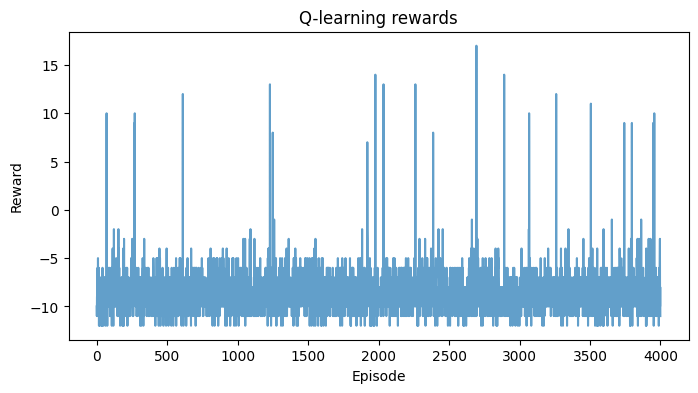

Results written to results_summary.txt


In [ ]:
# 12) Save/Load helpers
# -------------------------
def save_hmm(hmm, path="hmm_model.pkl"):
    with open(path, 'wb') as f:
        pickle.dump(hmm, f)

def load_hmm(path="hmm_model.pkl"):
    with open(path, 'rb') as f:
        return pickle.load(f)

# -------------------------
# 13) Example usage (run in main)
# -------------------------
if __name__ == "__main__":
    # ---- USER CONFIG ----
    DATA_PATH = "/content/data/Data/corpus.txt"   # update if different
    TRAIN_SPLIT = 0.8
    ALG = "qlearn"   # choose "qlearn" or "dqn"
    # ----------------------

    # 1) load corpus
    print("Loading corpus...")
    corpus = load_corpus(DATA_PATH)
    print(f"Loaded {len(corpus)} words.")
    random.shuffle(corpus)
    split_idx = int(len(corpus) * TRAIN_SPLIT)
    train_corpus = corpus[:split_idx]
    test_corpus = corpus[split_idx:]
    print(f"Train: {len(train_corpus)} | Test: {len(test_corpus)}")

    # 2) Train HMM
    hmm = CharHMM()
    print("Training HMM...")
    hmm.fit(train_corpus)
    save_hmm(hmm, "hmm_model.pkl")
    print("HMM saved to hmm_model.pkl")

    # 3) Choose RL algorithm
    if ALG == "qlearn":
        print("Training Q-learning agent (quick)...")
        q_agent, rewards = train_qlearning(train_corpus, hmm, episodes=4000, eval_every=1000)
        print("Q-learning training finished.")
        q_agent.save("q_agent.pkl")
        # evaluate on train & test
        print("\nEvaluate on training set:")
        stats_train = evaluate_policy(train_corpus, hmm, q_agent, alg="qlearn", n_games=500)
        print(stats_train)
        print("\nEvaluate on test set:")
        stats_test = evaluate_policy(test_corpus, hmm, q_agent, alg="qlearn", n_games=500)
        print(stats_test)
        plot_rewards(rewards, title="Q-learning rewards")
    else:
        print("Training DQN agent (requires torch)...")
        dqn_agent, rewards = train_dqn(train_corpus, hmm, episodes=2000, batch_size=64, eval_every=500)
        dqn_agent.save("dqn_agent.pth")
        print("\nEvaluate on training set:")
        stats_train = evaluate_policy(train_corpus, hmm, dqn_agent, alg="dqn", n_games=500)
        print(stats_train)
        print("\nEvaluate on test set:")
        stats_test = evaluate_policy(test_corpus, hmm, dqn_agent, alg="dqn", n_games=500)
        print(stats_test)
        plot_rewards(rewards, title="DQN rewards")

    # 4) Save final models & results summary
    with open("results_summary.txt", "w") as f:
        f.write(f"Algorithm: {ALG}\n")
        f.write(f"Train stats: {stats_train}\n")
        f.write(f"Test stats : {stats_test}\n")
    print("Results written to results_summary.txt")

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.6 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok


In [ ]:
# Colab-ready: Gradio Hangman UI (works without ngrok/ngrok token)
# Paste entire cell into a Colab cell and run it.

# 1) Install gradio
!pip install -q gradio

# 2) UI code
import gradio as gr
import random
import inspect
from collections import Counter

# Use existing objects if present; otherwise create simple fallbacks
USE_REAL_MODELS = ('hmm' in globals())
USE_AGENT = ('agent' in globals())

# If your functions exist, reuse them; else provide fallbacks
if 'get_candidates' in globals():
    _get_candidates = get_candidates
else:
    def _get_candidates(words, masked, guessed):
        L = len(masked)
        cands = []
        for w in words:
            if len(w) != L: continue
            ok = True
            for mc, ch in zip(masked, w):
                if mc != '_' and mc != ch:
                    ok = False; break
                if mc == '_' and ch in guessed:
                    ok = False; break
            if ok: cands.append(w)
        return cands

if 'hmm' in globals() and hasattr(hmm, 'predict_distribution'):
    _hmm = hmm
else:
    class SimpleHMM:
        def predict_distribution(self, candidates, masked_word):
            # fallback: count letter frequencies in candidates for empty positions
            pos_counts = [Counter() for _ in range(len(masked_word))]
            for w in candidates:
                for i,ch in enumerate(w):
                    if masked_word[i] == '_':
                        pos_counts[i][ch] += 1
            letter_scores = Counter()
            for cnt in pos_counts:
                for ch,v in cnt.items():
                    letter_scores[ch] += v
            total = sum(letter_scores.values())
            if total == 0:
                return {c:1/26 for c in "abcdefghijklmnopqrstuvwxyz"}
            return {ch: v/total for ch,v in letter_scores.items()}
    _hmm = SimpleHMM()

# If user has an 'agent' object with choose_action / act methods, we'll use it.
if 'agent' in globals():
    _agent = agent
else:
    # fallback agent: greedily pick highest-prob letter from HMM
    class FallbackAgent:
        def choose_action(self, masked, guessed, probs):
            # probs: dict letter->score
            remaining = [c for c in "abcdefghijklmnopqrstuvwxyz" if c not in guessed]
            if not remaining: return None
            return max(remaining, key=lambda c: probs.get(c,0))
        # compatibility in case code uses act(state)
        def act(self, state, explore=False, eps=0.05):
            # state is dict with 'masked','guessed_mask','hmm_probs' possibly; fallback not used
            masked = state.get('masked', '_'*26)
            guessed_mask = state.get('guessed_mask', None)
            guessed = set()
            if guessed_mask is not None:
                for i, val in enumerate(guessed_mask):
                    if val>0: guessed.add(chr(ord('a')+i))
            # try to build probs if present
            probs = {}
            if 'hmm_probs' in state:
                for i,p in enumerate(state['hmm_probs']):
                    probs[chr(ord('a')+i)] = float(p)
            else:
                for c in "abcdefghijklmnopqrstuvwxyz":
                    if c not in guessed: probs[c] = 1.0
            remaining = [c for c in probs.keys() if c not in guessed]
            if not remaining: return random.choice(list("abcdefghijklmnopqrstuvwxyz"))
            return ord(max(remaining, key=lambda c: probs.get(c,0))) - ord('a')
    _agent = FallbackAgent()

# Corpus: use existing 'corpus' variable if present, else a tiny sample
if 'corpus' in globals() and isinstance(corpus, list) and len(corpus) > 0:
    _corpus = corpus
else:
    _corpus = ["apple","banana","cherry","grapes","orange","papaya","peach","mango"]

ALPHABET = [chr(i) for i in range(ord('a'), ord('z')+1)]

# Reusable game runner that records step-by-step logs
def run_ai_game(word, use_real_models=True):
    word = word.lower().strip()
    masked = ['_'] * len(word)
    guessed = set()
    wrong = 0
    max_wrong = 6
    steps = []
    # loop until done
    while '_' in masked and wrong <= max_wrong:
        # get candidates from corpus
        cands = _get_candidates(_corpus, "".join(masked), guessed)
        probs = _hmm.predict_distribution(cands, "".join(masked))
        # choose via real agent if available
        if USE_AGENT and hasattr(_agent, 'choose_action'):
            # agent.choose_action(masked_str, guessed_set, probs)
            try:
                guess = _agent.choose_action("".join(masked), guessed, probs)
            except Exception:
                # fallback to greedy
                guess = max([c for c in ALPHABET if c not in guessed], key=lambda c: probs.get(c,0))
        elif USE_AGENT and hasattr(_agent, 'act'):
            # build a simple state for compatibility
            state = {
                'masked': "".join(masked),
                'guessed_mask': np.array([1.0 if c in guessed else 0.0 for c in ALPHABET], dtype=float),
                'hmm_probs': np.array([probs.get(c,0.0) for c in ALPHABET], dtype=float),
                'lives': [(max_wrong - wrong)/max_wrong]
            }
            try:
                idx = _agent.act(state, explore=False)  # agent.act returns index
                guess = ALPHABET[int(idx)]
            except Exception:
                guess = max([c for c in ALPHABET if c not in guessed], key=lambda c: probs.get(c,0))
        else:
            # fallback greedy
            guess = max([c for c in ALPHABET if c not in guessed], key=lambda c: probs.get(c,0))
        if guess in guessed:
            steps.append(f"Repeated guess '{guess}' (ignored). Mask: {''.join(masked)} Lives: {max_wrong-wrong}")
            # penalize repeated by counting as wrong? here we just note it
            # to keep behavior consistent with earlier code, do not increment wrong
            break_flag = False
            # continue to next iteration (but avoid infinite loop)
            # choose next best unguessed
            remaining = [c for c in ALPHABET if c not in guessed]
            if not remaining:
                break
            # remove this guess from consideration artificially
            guessed.add(guess)  # mark it to avoid loop
            continue
        guessed.add(guess)
        if guess in word:
            for i,ch in enumerate(word):
                if ch == guess:
                    masked[i] = guess
            steps.append(f"Guess '{guess}' → CORRECT. Mask: {''.join(masked)} Lives: {max_wrong-wrong}")
        else:
            wrong += 1
            steps.append(f"Guess '{guess}' → WRONG. Mask: {''.join(masked)} Lives: {max_wrong-wrong}")
        if wrong > max_wrong:
            break
    success = ('_' not in masked)
    if success:
        steps.append(f"🎉 AI WON! Word: {word}")
    else:
        steps.append(f"💀 AI LOST. Word was: {word}")
    return "\n".join(steps)

# Manual play simulation (step-by-step): accept a sequence of letters or single letter per call
def run_manual_game(word, guesses):
    word = word.lower().strip()
    masked = ['_'] * len(word)
    guessed = []
    wrong = 0
    max_wrong = 6
    log = []
    for g in guesses:
        if not g: continue
        letter = g.lower()
        if letter in guessed:
            log.append(f"Repeated '{letter}'. Mask: {''.join(masked)} Lives: {max_wrong-wrong}")
            continue
        guessed.append(letter)
        if letter in word:
            for i,ch in enumerate(word):
                if ch==letter: masked[i]=letter
            log.append(f"'{letter}' → CORRECT. Mask: {''.join(masked)} Lives: {max_wrong-wrong}")
        else:
            wrong += 1
            log.append(f"'{letter}' → WRONG. Mask: {''.join(masked)} Lives: {max_wrong-wrong}")
        if wrong > max_wrong:
            break
        if '_' not in masked:
            break
    success = ('_' not in masked)
    if success:
        log.append(f"🎉 You WON! Word: {word}")
    elif wrong > max_wrong:
        log.append(f"💀 You LOST. Word was: {word}")
    else:
        log.append(f"🔁 Game paused. Mask: {''.join(masked)} Lives: {max_wrong-wrong}")
    return "\n".join(log)

# Gradio UI functions
def ai_play_ui(word):
    if not word or len(word.strip())==0:
        # pick random from corpus
        word = random.choice(_corpus)
    return run_ai_game(word, use_real_models=USE_REAL_MODELS)

def manual_play_ui(word, guess_sequence):
    # guess_sequence is a comma-separated string of letters user wants to apply sequentially
    if not word or len(word.strip())==0:
        return "Please enter a word to play (in the top box)."
    guesses = [g.strip().lower() for g in guess_sequence.split(",") if g.strip()]
    return run_manual_game(word, guesses)

# Build Gradio interface using Blocks
with gr.Blocks() as demo:
    gr.Markdown("## 🤖 Hangman UI — Manual & AI modes (Colab-friendly)")
    with gr.Row():
        with gr.Column(scale=2):
            word_input = gr.Textbox(label="Word to test (leave empty for random)", placeholder="enter a word (e.g. recieve)")
            mode = gr.Radio(["AI Play (auto)", "Manual Play (supply guesses)"], label="Mode")
            guess_seq = gr.Textbox(label="Manual guesses (comma-separated, e.g. r,e,c,i,e)", visible=True)
            run_btn = gr.Button("Start / Run")
        with gr.Column(scale=3):
            output = gr.Textbox(label="Step-by-step log", interactive=False)
            sample_btn = gr.Button("Use random sample word")
    def on_run(word, mode_val, guess_seq_val):
        if mode_val == "AI Play (auto)":
            return ai_play_ui(word)
        else:
            return manual_play_ui(word, guess_seq_val)
    run_btn.click(on_run, inputs=[word_input, mode, guess_seq], outputs=output)
    sample_btn.click(lambda : gr.update(value=random.choice(_corpus)), None, word_input)

# Launch the app: share=True gives a public link right inside Colab
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ac61be0d369bb1e8ba.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
